In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.animation as anm
#import matplotlib.gridspec as gridspec

Class Cat


In [2]:
class Cat:
    def __init__(self, resolution, areas_dict:dict):
        self.resolution = resolution
        self.areas_dict = areas_dict
        self.matrices = {}
        self.set_start_matrices()
        self.total_matrix = []
        self.create_total_matrix()

    
    def set_start_matrices(self):
        for key in self.areas_dict.keys():
            x_0 = min(tup[0] for tup in self.areas_dict[key])
            x_1 = max(tup[0] for tup in self.areas_dict[key])
            y_0 = min(tup[1] for tup in self.areas_dict[key])
            y_1 = max(tup[1] for tup in self.areas_dict[key])
            self.matrices[key] = np.random.randint(100, size=(x_1 - x_0, y_1 - y_0)) 

    
    def create_total_matrix(self):
        x_max = self.resolution[0]
        y_max = self.resolution[1]
        self.total_matrix = np.zeros((y_max, x_max))
        for key in self.areas_dict.keys():
            x_0 = min(tup[0] for tup in self.areas_dict[key])
            x_1 = max(tup[0] for tup in self.areas_dict[key])
            y_0 = min(tup[1] for tup in self.areas_dict[key])
            y_1 = max(tup[1] for tup in self.areas_dict[key])
            self.total_matrix[(y_max-y_1):(y_max-y_0), (x_0):(x_1)] = (self.matrices[key]).T
    
    def show_total_matrix(self): 
        plt.imshow(self.total_matrix)

    

In [5]:
areas_dict = {
  "leg_1": [(40,0), (40, 30), (50, 30), (50, 0)],
  "leg_2": [(60,0), (60, 30), (70, 30), (70, 0)],
  "leg_3": [(110, 0), (110, 30), (120, 30), (120, 0)],
  "leg_4": [(130, 0), (130, 30), (140, 30), (140, 0)],
  "body": [(40, 30), (40, 70), (140, 70), (140, 30)],
  "tail": [(40, 70),(40, 100), (50, 100), (50, 70)],
  "head": [(140, 50), (140, 80), (170, 80), (170, 50)]
}

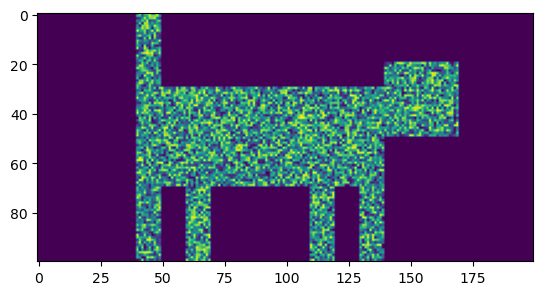

In [6]:
cat1 = Cat([200, 100], areas_dict)
cat1.show_total_matrix()

Mathematical model: **Gierer-Meinhardt model**

$$\frac{\partial a}{ \partial t} = \rho \frac{a^2}{h} - \mu_a a + D_a \Delta a + \rho_a$$

$$\frac{\partial h}{ \partial t} = \rho a^2 - \mu_h h + D_h \Delta h + \rho_h,$$

where $ \Delta f(x,y) = \frac{\partial^2 f}{ \partial x^2} + \frac{\partial^2 f}{ \partial y^2}$.


The above model is a reaction-diffusion system of the activator-inhibitor type, so it describes the pattern formation.

Variables:

* $a$: *activator* - the substance responsible for the intensity of the pigment,

* $h$: *inhibitor* - the antagonist which controls value of $a$.


The first eqaution - change of activator concentration $\frac{\partial a}{ \partial t}$:

* $\rho \frac{a^2}{h}$: the production rate (it depends in non-linear way of $a$ and is slowed down by the inhabitor $1/h$),

* $- \mu_a a$: the number of molecules that decay per time unit (proportial to the decay rate $\mu_a$ and $a$),

* $D_a \Delta a$: the exchange (diffusion) of molecules,

* $\rho_a$: small activator-independent production rate.

The meaning of the second equation for $\frac{\partial h}{ \partial t}$ is analogous.

Let's assume that the unit of the change time $t$ is equal 30 days.


We will assume that the initial pigment distribution is random and indepenedent in each part of the body (head, body, tail and legs).

In this case we assume that there is no flow at the edges: **homogeneous Neumann conditions**:

$$ \frac{\partial a}{∂ n} (x,y,t) = \nabla a (x,y,t) ⋅ n(x,y) = g(t) = 0,$$

$$ \frac{\partial h}{∂ n} (x,y,t) = \nabla h (x,y,t) ⋅ n(x,y) = g(t) = 0.$$


We will find the numerical scheme **for each part of the body separately** (for the rectangles: $[0,L] \times [0,M]$).


**Finite difference numerical scheme**

At the beginning we will approximate the value of Laplace operator:

$$Δ a = a_{xx}(x,t)\approx \frac{a(x+h_x,t) - 2 a(x,t) + a(x-h_x,t)}{h_x^2}.$$


So:

\begin{align}
  Δa(x, y, t) &≈ \frac{∂^2a(x,y,t)}{∂x^2} + \frac{∂^2a(x,y,t)}{∂y^2} ≈  \\
  &≈ \frac{a(x + h_x, y, t) - 2a(x, y, t) + a(x - h_x, y, t)}{h_x^2} + \frac{a(x, y + h_y, t) - 2a(x, y, t) + a(x, y - h_y, t)}{h_y^2}.
\end{align}

We get the analogical formula for $Δ h$.

* We have:

$$a_t = \rho \frac{a^2}{h} - \mu_a a + D_a \Delta a + \rho_a / \int_t^{t+h_t}$$

$$a(x, y, t+h_t) ≈ a(x,y,t) + h_t \cdot(\rho \frac{a^2}{h} - \mu_a a + D_a \Delta a + \rho_a).$$

In matrix notation:

$$a_{i,j,k+1} ≈ a_{i,j,k} + h_t \cdot(\rho \frac{a_{i,j,k}^2}{h_{i,j,k}} - \mu_a a_{i,j,k} + D_a \Delta a_{i,j,k} + \rho_a).$$

* Similarly for the second equation:

$$h_t = \rho a^2 - \mu_h h + D_h \Delta h + \rho_h / \int_t^{t+h_t}$$

$$h(x, y, t+h_t) ≈ h(x,y,t) + h_t \cdot(\rho a^2 - \mu_h h + D_h \Delta h + \rho_h).$$

So:

$$h_{i,j,k+1} ≈ h_{i,j,k} + h_t \cdot(\rho a_{i,j,k}^2 - \mu_h h_{i,j,k} + D_h \Delta h_{i,j,k} + \rho_h).$$

The above formulas are correct for $(x_i, y_j) \notin \partial\Omega$. Moreover, using the homogeneous Neumann conditions ($g(t)=0$) we get at the edge:

$$
\mathrm{u}_{i, j, k+1} = \begin{cases}
    u_{L-1, j, k+1} + h_x g(t_{k+1})  & \text{if } x_i = L, 0 \leq y_j \leq M, \\
    u_{1, j, k+1} + h_x g(t_{k+1}) & \text{if } x_i = 0, 0 \leq y_j \leq M, \\
    u_{i, L-1, k+1} + h_x g(t_{k+1}) & \text{if } 0 \leq x_i \leq L, y_j = M, \\
    u_{i, 1, k+1} + h_x g(t_{k+1}) & \text{if } 0 \leq x_i \leq L, y_j = 0,
\end{cases}
$$

where $u = a$ or $u = h$.